In [112]:
import os
import json
import pandas as pd

In [113]:
folder_base = './results'
folder_baseline = './results_baseline'

csv_file = 'results_summary.csv'


In [114]:
# Define a function to process a single file
def process_file(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Extract columns, using placeholders for missing data
    scenario_name = data.get("model_file", "-").replace('.json', '')
    algorithm = data.get("configuration", {}).get("algorithm", "-")
    size = data.get("configuration", {}).get("size", "-")
    optimizer = data.get("configuration", {}).get("optimizer", "-")
    annealings = data.get("configuration", {}).get("nonlinear_annealings", "-")
    iterations = data.get("configuration", {}).get("nonlinear_iterations", "-")

    reasoner = data.get("reasoner_results", {})
    if isinstance(reasoner, str):
        print(f"File {filepath} has reasoner results as a string, converting to dict.")
        reasoner = {"status": reasoner}
    status = reasoner.get("status", "-")
    score = reasoner.get("score", "-")
    evaluation = reasoner.get("evaluation", "-")
    exec_time = reasoner.get("solver_exec_time", "-")
    total_cost = reasoner.get("total_cost", "-")
    max_time = reasoner.get("max_time", "-")
    dispatch = reasoner.get("dispatch", {})

    if optimizer == "linear":
        baseline = "qb-linear"
    elif optimizer == "nonlinear":
        baseline = "qb-nonlinear"
    else:
        baseline = "unknown"
    
    # Row for DataFrame
    row = {
        "baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        "optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        "score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        "total_cost": total_cost,
        "max_time": max_time,
    }
    
    # Key for dispatches dict
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    
    return row, dispatch_key, dispatch

In [115]:
def process_file_baseline(filepath, scenario_name):
    with open(filepath, 'r') as f:
        data = json.load(f)
    algorithm = data.get("algorithm", "-")
    size = data.get("size", "-")
    optimizer = "-"  
    annealings = "-"
    iterations = "-"
    status = "-" 
    score = "-"
    evaluation =  data.get(scenario_name+"_value", "-")
    exec_time = "-"
    total_cost = data.get("total_cost", "-")
    max_time = data.get("max_time", "-")
    dispatch = data.get("dispatch", {})
    baseline = os.path.basename(filepath).replace(algorithm+"_", "").replace(str(size)+"_", "").replace(".json", "")
    row = {
        "baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        "optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        "score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        "total_cost": total_cost,
        "max_time": max_time
    }
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    return row, dispatch_key, dispatch

In [116]:
data_rows = []
dispatches = {}

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)    
else:
    base_files = [os.path.join(folder_base, f) for f in os.listdir(folder_base) if f.endswith('.json')]
    baseline_files = [os.path.join(folder_baseline, f) for f in os.listdir(folder_baseline) if f.endswith('.json')]
    for file in base_files:
        row, key, dispatch = process_file(file)
        data_rows.append(row)
        dispatches[key] = dispatch
    
    for file in baseline_files:
        for scenario_name in ["scenario1", "scenario2", "scenario3"]:
            row, key, dispatch = process_file_baseline(file, scenario_name)
            data_rows.append(row)
            if key in dispatches:
                continue
            else:
                dispatches[key] = dispatch

    # Create DataFrame
    df = pd.DataFrame(data_rows)

# Show results
print("DataFrame:")
display(df)

#print("\nDispatches dictionary (keys and values):")
#for k, v in dispatches.items():
#    print(f"{k}: {v}")

# if csv is already present, skip saving
if not os.path.exists(csv_file):
    df.to_csv(csv_file, index=False)

DataFrame:


,baseline,scenario_name,algorithm,size,optimizer,annealings,iterations,status,score,evaluation,exec_time,total_cost,max_time
0,qb-linear,scenario1,qaoa,6,linear,-,-,solution_found,986.352594306552,602.007717392393,0.0226149782538414,483.45543478478623,720.56
1,qb-linear,scenario1,qaoa,8,linear,-,-,solution_found,986.352594306552,602.007717392393,0.022190652787685394,483.45543478478623,720.56
2,qb-linear,scenario3,ghz,6,linear,-,-,solution_found,565.32,533.0400000000001,0.016397694125771523,614.7830155095629,533.0400000000001
3,qb-linear,scenario1,qnn,8,linear,-,-,solution_found,536.4831160074561,317.0453467369869,0.019741550087928772,247.13069347397382,386.96000000000004
4,qb-linear,scenario3,qft,10,linear,-,-,solution_found,265.6,229.51999999999998,0.01751881092786789,200.07617253840908,229.51999999999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,all_sherbrooke,scenario2,qaoa,8,-,-,-,-,-,-225.16516748774657,-,225.16516748774657,2542.6700000000005
716,all_sherbrooke,scenario3,qaoa,8,-,-,-,-,-,2542.6700000000005,-,225.16516748774657,2542.6700000000005
717,all_fez,scenario1,qnn,8,-,-,-,-,-,810.465806011304,-,362.01161202260806,1258.92
718,all_fez,scenario2,qnn,8,-,-,-,-,-,-362.01161202260806,-,362.01161202260806,1258.92


In [117]:
df.columns

Index(['baseline', 'scenario_name', 'algorithm', 'size', 'optimizer',
       'annealings', 'iterations', 'status', 'score', 'evaluation',
       'exec_time', 'total_cost', 'max_time'],
      dtype='object')

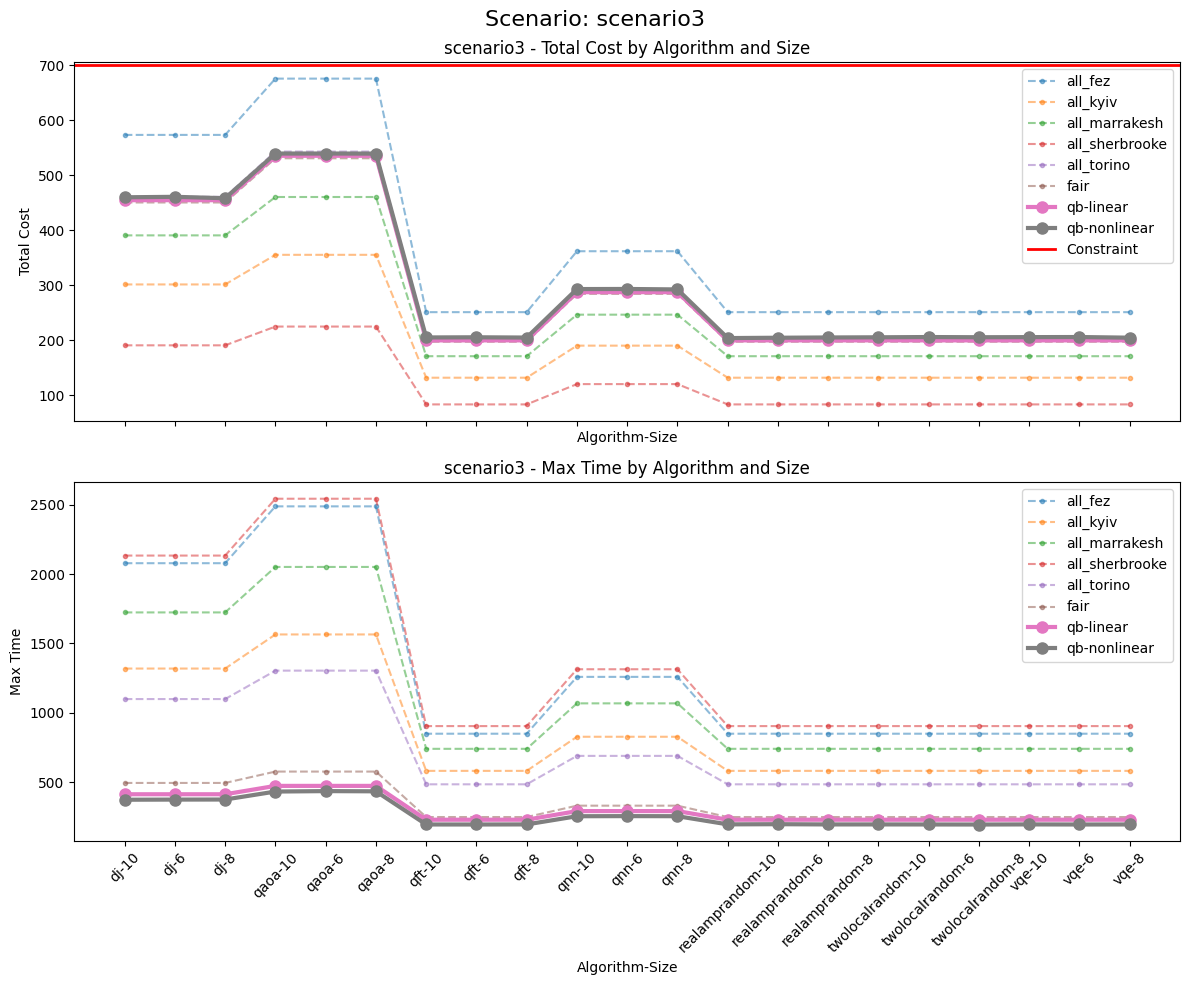

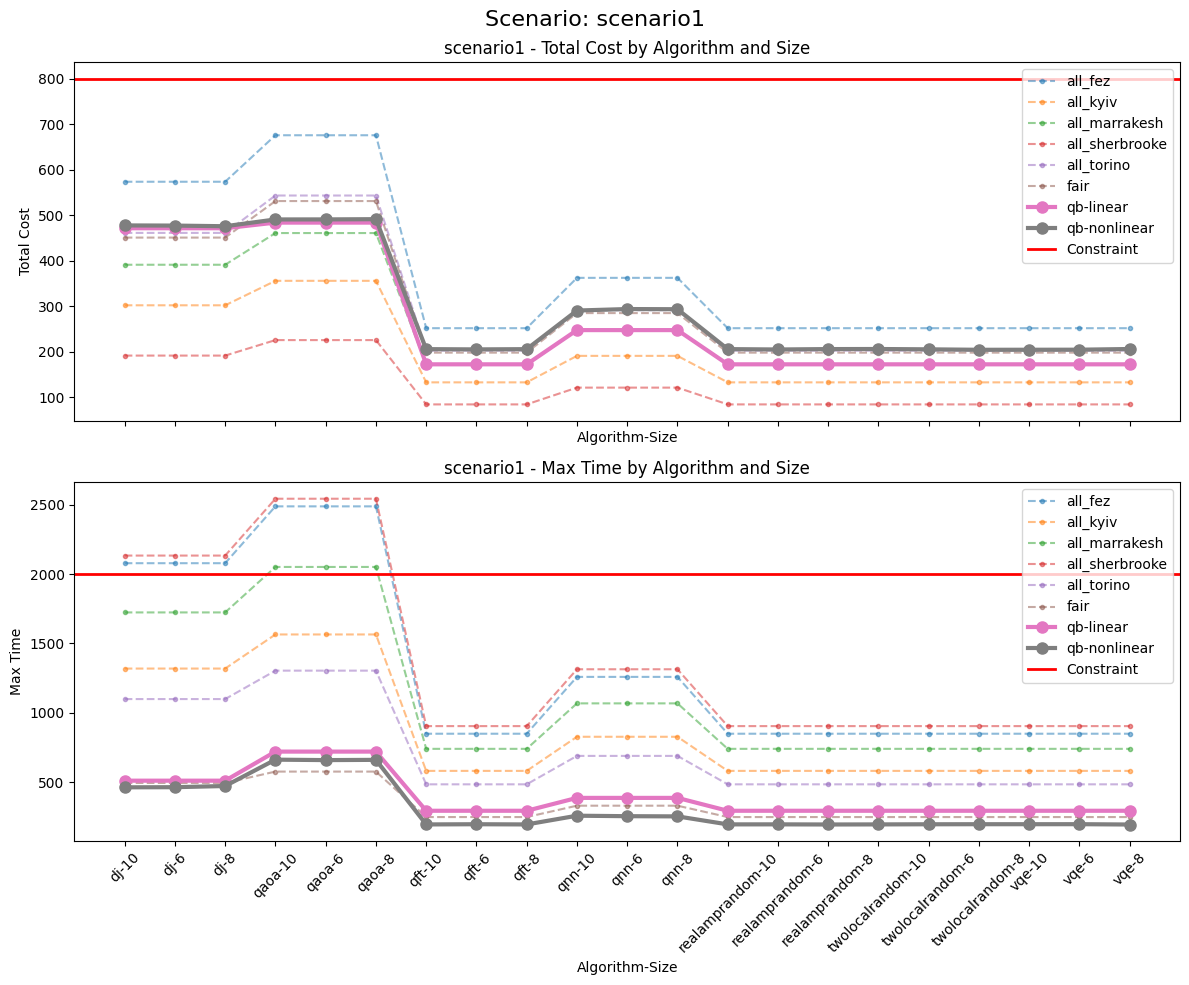

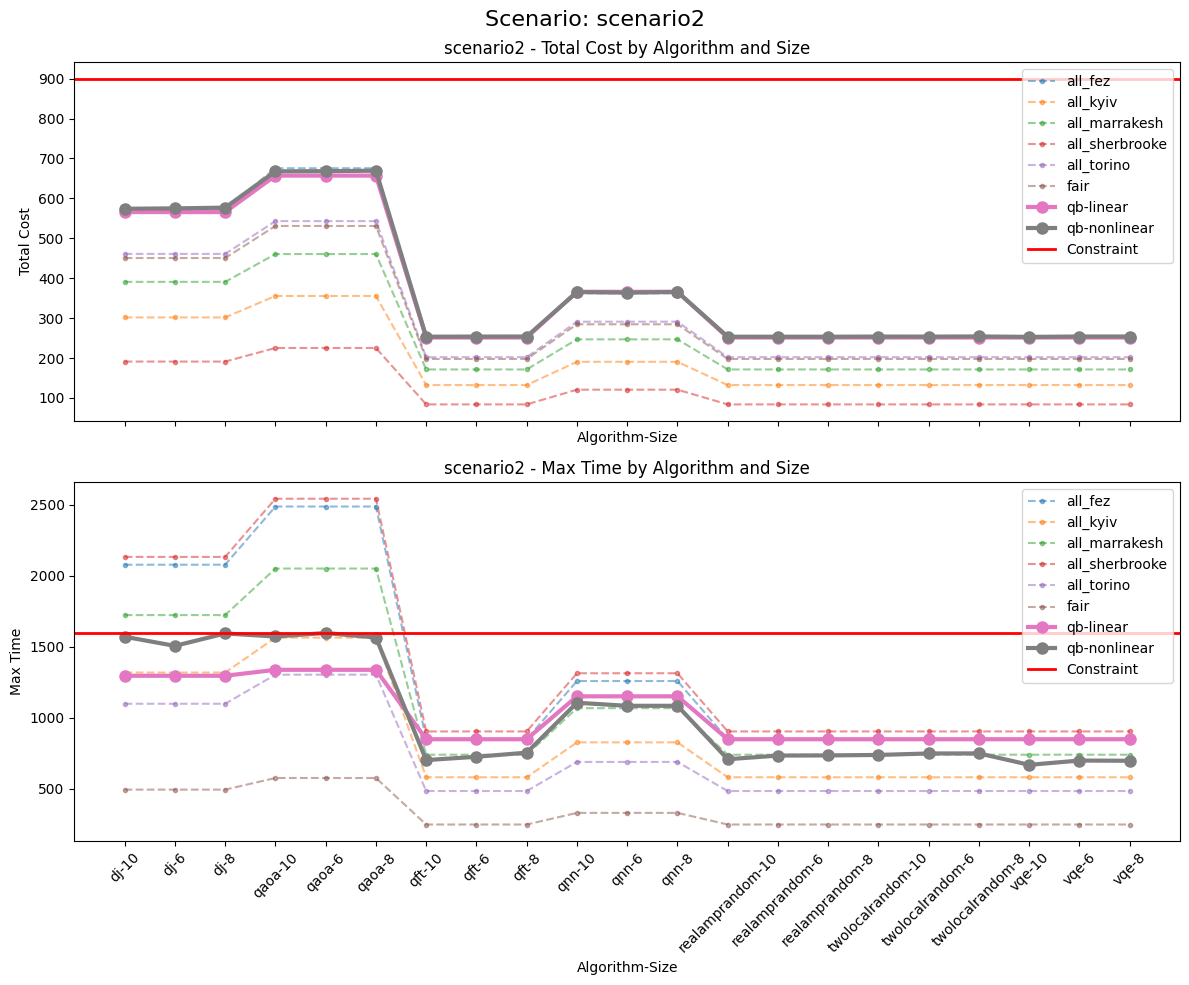

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


_df = df[df['status'].isin(['solution_found', '-'])]
_df = _df[_df['algorithm'] != 'ghz']
_df = _df[_df['algorithm'] != 'qpeexact']
_df = _df[_df['algorithm'] != 'wstate']

# Coerce total_cost to numeric (any non-numeric becomes NaN) and drop those rows
_df['total_cost'] = pd.to_numeric(_df['total_cost'], errors='coerce')
_df['max_time'] = pd.to_numeric(_df['max_time'], errors='coerce')

_df = _df.dropna(subset=['total_cost'])
_df = _df.dropna(subset=['max_time'])

# Sort by algorithm name and size
_df = _df.sort_values(['algorithm', 'size'])
_df['alg_size'] = _df['algorithm'] + '-' + _df['size'].astype(int).astype(str)

my_baselines = {'qb-linear', 'qb-nonlinear'}

constraints = { "scenario1": {"total_cost": 800, "max_time": 1000},
               "scenario2": {"total_cost": 750, "max_time": 1700},
               "scenario3": {"total_cost": 700, "max_time": 0} }

for scenario in _df['scenario_name'].unique():
    df_s = _df[_df['scenario_name'] == scenario]

    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Scenario: {scenario}", fontsize=16)

    for i, ycol in enumerate(['total_cost', 'max_time']):

        pivot = df_s.pivot(
            index='alg_size',
            columns='baseline',
            values=ycol
        )

        axes[i].set_title(f'{scenario} - {ycol.replace("_", " ").title()} by Algorithm and Size')
        for baseline in pivot.columns:
            if baseline in my_baselines:
                axes[i].plot(pivot.index, pivot[baseline], marker='o', linewidth=3, markersize=8, label=baseline)
            else:
                axes[i].plot(pivot.index, pivot[baseline], marker='.', linestyle='--', alpha=0.5, label=baseline)

        constraint_value = constraints[scenario][ycol]
        if constraint_value > 0:
            axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label='Constraint')
        axes[i].set_xlabel('Algorithm-Size')
        axes[i].set_ylabel('Total Cost' if ycol == 'total_cost' else 'Max Time')
        axes[i].set_title(f'{scenario} - {ycol.replace("_", " ").title()} by Algorithm and Size')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend()
    plt.tight_layout()
    plt.show()